In [410]:
#импорт библиотек
from warnings import filterwarnings
filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA


1. 
    * Прочитайте исходный файл с данными. 
    * Визуализируйте исходный временной ряд
    * Сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
    * Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [411]:
#Прочитаем данные и приведем в удобный вид (Год в формате номера года, названия фич к одному регистру)
data = pd.read_csv('ghana_gdp.csv', parse_dates=['year'])
data = data.rename({'GDP (current US$)':'GPD'}, axis=1)
data['year'] = pd.to_datetime(data['year'])
#data['year'] = data['year'].dt.year
data = pd.DataFrame(data['GPD'].values, index=data['year']).rename({0:'gpd'},axis=1)
data.head(3)

,gpd
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09


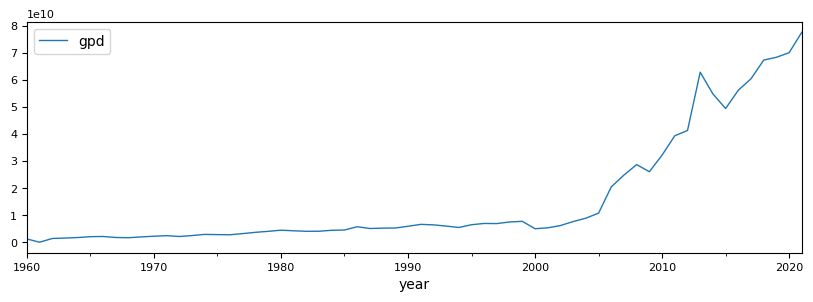

In [412]:
# Визуализируем ряд как он есть
%matplotlib inline

plt.rcParams["figure.figsize"] = 10, 3
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["lines.linewidth"] = 1

data.plot()
plt.show()

- - -
    Выводы:
    - Сезонности не видно (да и оно логично, ВВП стран +/- расчет в длинной динамике по годам)
    - Тренд есть, более того график можно разделить на 2е явно выраженные части по тренду, в каждой их которых трнед примерно линейный. Виден "слом тренда" на более высокие темпы роста с середины 2000х
    - Стационарности вообще, я бы не предполагал т.к. тренд явно выражен, а значит матожидание в период 2010+, например, явно отличается от матожидания до 2000


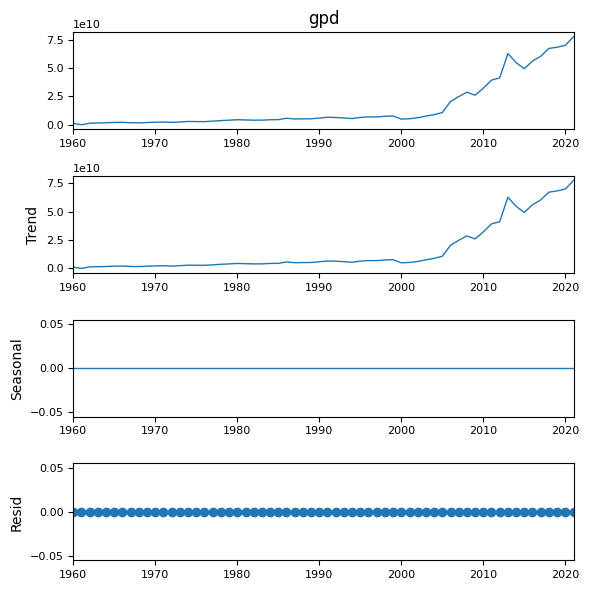

In [413]:
# Посмотрим, как на тренд и сезонную составляющую через метод сезонной декомпозиции
plt.rcParams["figure.figsize"] = 6, 6

result = seasonal_decompose(data.gpd)
result.plot()
plt.show()

- - -
    Видим, что выделяется один тренд. Рискну предположить, что модели прогнозирования сработают хорошо, т.к. у нас нет ни шумов, ни сезонности, а тренд "на глаз" состоит из двух линейных кусков

In [414]:
#Разделим выборку на тестовую и тренировочную. В тренировочную положим последние 3 года
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

2. * Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
    * Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

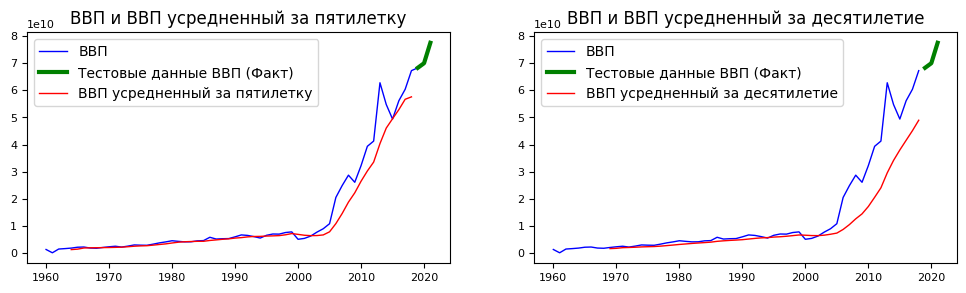

In [415]:
#plt.rcParams["figure.figsize"] = 12, 3

fig, ax = plt.subplots(1, 2, figsize=(12,3))

# Окно в Пятилетку
ax[0].plot(data['gpd'], color="blue", label="ВВП")
ax[0].plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ax[0].plot(
    train_df['gpd'].rolling(window=5).mean(),
    color="red",
    label="ВВП усредненный за пятилетку",
)

ax[0].set_title("ВВП и ВВП усредненный за пятилетку")
ax[0].legend()

# Окно в Десятилетие
ax[1].plot(train_df['gpd'], color="blue", label="ВВП")
ax[1].plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ax[1].plot(
    train_df['gpd'].rolling(window=10).mean(),
    color="red",
    label="ВВП усредненный за десятилетие",
)

ax[1].set_title("ВВП и ВВП усредненный за десятилетие")
ax[1].legend()

plt.show()

- - -
    Выводы:
    - Чем больше период окна, тем больше MA отстает от изменения тренда
    - В целом MA конечно плохо прогнозирует такую картинку, когда тренд резкий, оценка занижена или завышена. Тут вопрос и в том как "продалять" правильно красную линию скользящего среднего до прогноза и не надо ли ее "адаптировать" к более свежим данным. 
    - Тут кстати должна лучше сработать из простых модель экспоненциального сглаживания, т.к. "свежие данные" сильнее влияют. Давайте проверим эту гипотезу ниже (понятно, что тут есть явное когнитивное искажение, т.к. факт уже нарисован на картинке и я подбираю модель, которая луше предскажет видимый глазом результат, но все равно интересно):

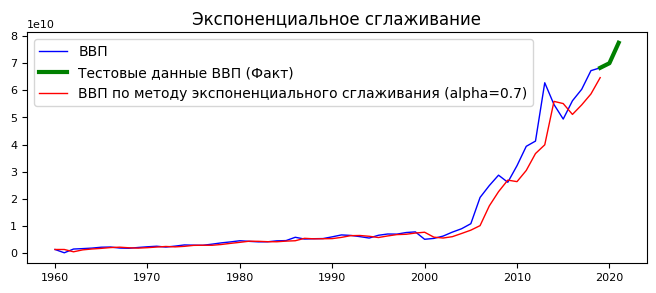

In [416]:
# Попробуем эеспоненциальное сглаживание. Тут логично его применить и интересно,ч то получится
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(train_df)
model = ses.fit(smoothing_level = 0.7, optimized = False)
#print(model.fittedvalues)

#plt.rcParams["figure.figsize"] = 8, 3

fig, ax = plt.subplots(1, 1, figsize=(8,3))

# Окно в Пятилетку
ax.plot(data['gpd'], color="blue", label="ВВП")
ax.plot(test_df['gpd'], color="green", label="Тестовые данные ВВП (Факт)", lw=3)

ses_graph = pd.concat([model.fittedvalues, model.forecast(1)], axis=0)
ax.plot(
    ses_graph,
    color="red",
    label="ВВП по методу экспоненциального сглаживания (alpha=0.7)",
)

ax.set_title("Экспоненциальное сглаживание")
ax.legend()


- - -
    Вывод:
    - Подгоняя модель под ответ, получили более точный прогноз (кто бы сомневался :) )
    - И все равно методы усреднения "подстраховываются", ну явно линейная часть тренда "красной линии" ниже, чем нужно

3.  * С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
    * Параметры p и q выберите по коррелограммам ACF и PACF.
    * Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
    * Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [417]:
# Сделем тест на стационарность. Проверим заодно мою гипотезу о нестационарности исходных данных
# Напишем функцию, которая возвращает чилсо дифференцирований до стационарности
def get_static_depth(x):
    row = x.copy()
    for i in range(10):
        test1 = adfuller(row)
        if test1[0] <= test1[4]["5%"]:
            return i
        
        row = row.diff().dropna()
        
    print('Нестационарен при 9 дифференцированиях')
    return -1
    
get_static_depth(train_df)    

3

- - -
    - Получили самое глубокое дифференцирование из всех примеров, которые пока я видел. Я думал хватит 2х, если честно (хотя было ясно, что не хватит одного)
    - Мне очень интересно, как ряд меняется при дифференцированиях, поэтому сделаю визуализацию:


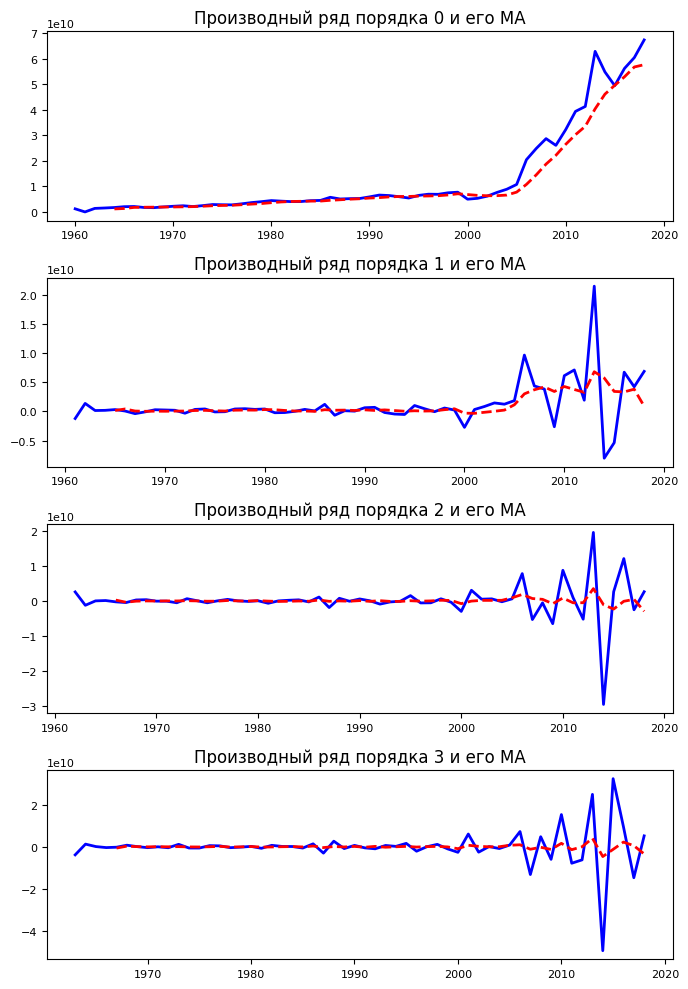

In [418]:
#Визуализация ряда и его последовательных "производных" до 3его порядка
diff_row = train_df.copy()
fig, ax = plt.subplots(4, 1, figsize=(7,10))
#plt.rcParams["figure.figsize"] = 7, 10

for i in range(4):
    ax[i].plot(diff_row['gpd'], color="blue", lw=2)
    ax[i].plot(diff_row['gpd'].rolling(window=5).mean(), color="red", linestyle='--', lw=2)
    diff_row = diff_row.diff().dropna()
    title = f'Производный ряд порядка {i} и его MA'
    ax[i].set_title(title)
plt.tight_layout()


- - -
    Выводы и наблюдение:
    - Есть новая гипотеза, что второй производный ряд был близок к стационарности
    - Скользящее среднее я вывед не только для красоты, но чтобы увидеть наглядно, что среднее значение ряда одинаково в итоговом ряде
    - Ну и будем использовать ARIMA т.к. она применяется для нестационарныз рядок
    - Порядок дифференцирования d для ARIMA уже определили и он = 3
    - Наглядно видно, что дисперсия увеличивается со временем. Это будем учитывать позже, сначала построим модели, которые не учитывают это.

    Далее подберем параметры p и q количества переменных авторегресии и скользящего среднего шумовой компоненты соответственно:


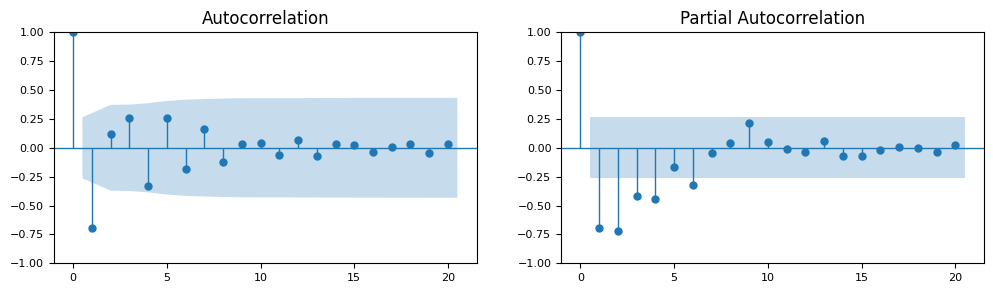

In [419]:
#Построим кореллограммы для 3его производного ряда, чтобы определиться с параметрами p и q
fig, ax = plt.subplots(1, 2, figsize=(12,3))

#plt.rcParams["figure.figsize"] = 12, 3
sgt.plot_acf(diff_row, ax=ax[0], lags=20)
sgt.plot_pacf(diff_row, ax=ax[1], lags=20, method="ywm")
plt.show()

- - -
    - Определяем p по графику частичной автокорреляции (правому). Я бы попробовал 4 и 6. Думаю, что 4 будет лучше.
    - Определяем q по графику автокорреляции (левому) и это 1 без вариантов
    
    Проверим сразу свои выводы с помошью инструментария pmdarima:

In [420]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.06 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.06 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.310 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 24 Jul 2023   AIC                           2659.231
Time:                        22:24:02   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.72e+56. Standard errors may be unstable.
"""

- - -
    Меня немного смущает, что вышло предупреждение о том, что где-то возникла вырожденная или почти вырожденная матрица, но значение p=2 тоже попробуем. В этом есть смысл, т.к. оно самое большое по модулю среди всех "которые не в окрестности нуля", хотя это и не последний такой лаг на графике частичной автокорреляции.

    И еще момент: инструмент не перебрал p>3 и как я понял прервал работу. Я не понял почему.

    Далее все-таки сравним и вручную AIC на 3х моделях. Получается d=3,q=1, в вот на p у нас 3 кандиадата: 2,4,6

In [421]:
#Ради интереса, я включил AIC на разные p в диапазоне, чтобы посмотреть, как он меняется
for i in list(range(2,9)):
    arima_model = ARIMA(train_df, order=(i, 3, 1))
    arima_model_fit = arima_model.fit()
    print(f'При p = {i}, AIC = {arima_model_fit.aic}')

При p = 2, AIC = 2659.230811357536
При p = 3, AIC = 2660.791106443029
При p = 4, AIC = 2647.935669815345
При p = 5, AIC = 2646.8702217508835
При p = 6, AIC = 2629.1399230938837
При p = 7, AIC = 2626.991165414406
При p = 8, AIC = 2629.141684626863


- - -
    Выводы и наблюдения:
    - Я специально запустил алгоритм на рызных p в качетве наблюдения, чтобы понять, что происходит
    - Вообще говоря, луший AIC получился на значении 7. Что меня очень удивило. 7 по логике "отклонения от 0", не выбирается
    - Базовой = оптимальной моделью буду считать модель при p=6, т.к. это дает минимальный AIC и при этом подходит под алгоритм "будем обращать внимание на последний лаг, сильно отличный от нуля"
    - Но чтобы до конца разобраться, я построю прогнозы для других вариантов p, очень интерсно какое будет отличие между прогнозами

4. * Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
5. * Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

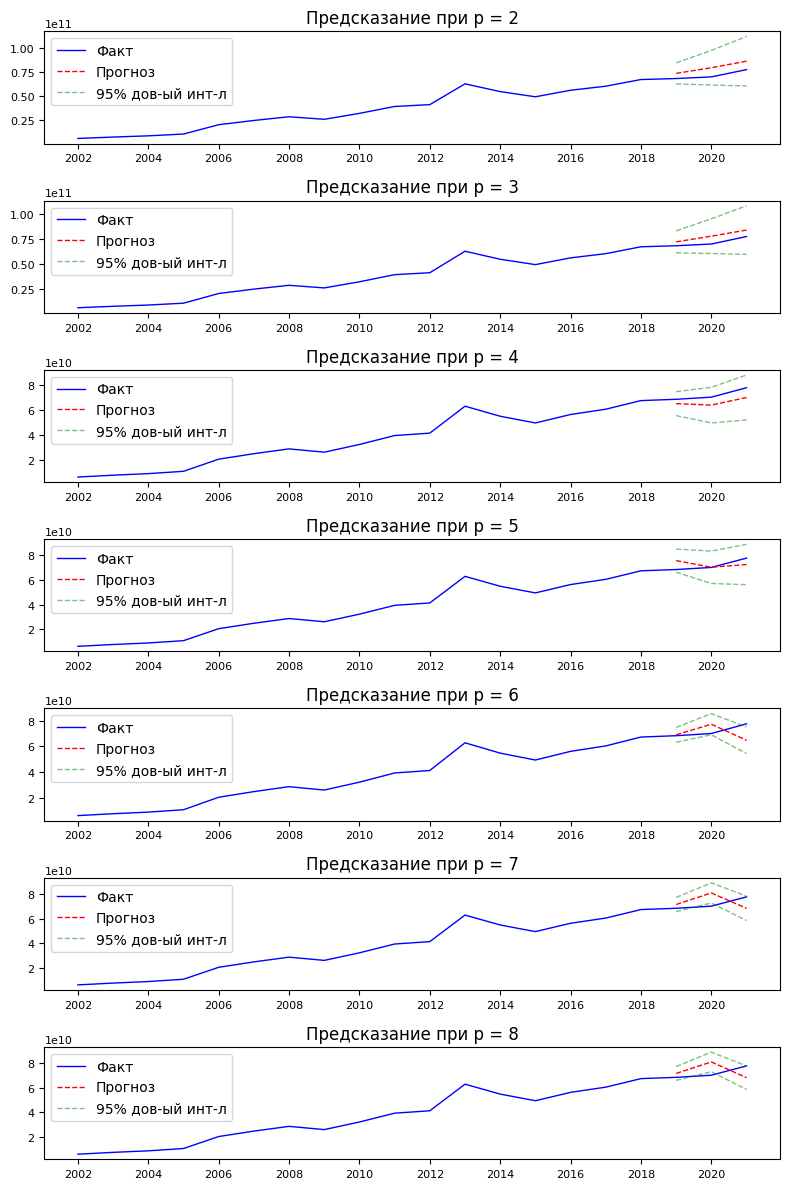

In [422]:
#Зададим список значений p для которых будем делать прогноз и рисовать график. 
p_list = [2,3,4,5,6,7,8]
fig, axes = plt.subplots(len(p_list), 1, figsize=(8,12))


for i,p in enumerate(p_list):
    #Обучим модель для каждого p из списка
    arima_model = ARIMA(train_df, order=(p, 3, 1))
    arima_model_fit = arima_model.fit()
    #Создадим таблицу итоговых данных для визуализации результатов по текущей модели
    pred_df = pd.DataFrame(index=data.index)
    pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
    pred_df["gpd"] = data["gpd"]
    forecast = arima_model_fit.get_forecast(len(test_df.index))
    forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
    pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gpd"]
    pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gpd"]
    pred_df = pred_df.iloc[-20:,:]
    #Собственно нарисум резельтат модели при текущем p на i-ой оси
    label = 'Предсказание при p = '+str(p)
    ax = axes[i]
    
    ax.plot(pred_df["gpd"], color="blue", label="Факт")
    ax.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="--",label="Прогноз")
    ax.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="95% дов-ый инт-л",alpha=0.5)
    ax.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.5)
    ax.set_title(label)
    ax.legend()

plt.tight_layout()
#display(pred_df.iloc[-30:,:])

6. * Сделайте выводы по полученным результатам.

- - -
    Выводы и наблюдения:
    - Честно говоря, по графикам я делаю вывод, что я ошибся в выборе оптимального p. По мне так верное p = 4. Т.к. оно отражает общий тренд линейно вверх, но при этом занижает интервал доверительный вниз, на возможнрые изломы/отскоки, какой например был в 2012-2015 годах
    - Я специально делаю задания последовательно, для чистоты исследования и не корректирую предыдущие выводы. И хочу отметить, что по коррелограмме частичной автокорреляции, я выбирал именно p=4. Оно мне показалось самым перспективным кандидатом т.к. заметно сильнее выходило из "0ой зоны", чем 6.
    - Я думаю, что тут есть большая зависимость от задачи, и в принципе модель стоит стараться пробовать разные пограничные значения. Причем еще желательно тестировать на разных кусках временного ряда прогноз (устраивать что-то типа кросс-валидации) и подбирать такие параметры, которые показали лучшие результаты прогноза на этой "кросс-валидации". Например нарезать последние 12 лет на периоды по три месяца и выбирать параметры, которые покажут лучший прогноз посделоваьтельно на последние 3 года, 3 года до этого и т.д.. Или как-то похожим образом
    - Не уверен, что это общая закономерность для большинства рядов, но при уменьшении модуля ковариации на коррелограмме интервал доверительный сужается, и повышается возможное влияние нелинейностей в данных. Например, мне кажется, что на форму прогноза при p=6-8 повлиял излом в данных в 2012-2015 годах и он "как-бы" стал влиятельнее, чем общий линейный тренд. Вот такая гипотеза.


7. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq().

- - -
    Проверим сколько у нас различных записей. Если их столько же сколько лет, то хорошо. 
    Но теоретически какая-то из записей может быть не датой начала года. А например две даты одного года. Проверим это посчитав количество различных годов. 

In [423]:
print('Число различных годов =', len(set(pd.DataFrame(data.index)['year'].dt.year.values)))
print('минимальный год', data.index.min(),', а максимальный',data.index.max())

Число различных годов = 62
минимальный год 1960-01-01 00:00:00 , а максимальный 2021-01-01 00:00:00


- - -
    У нас 62 года с 1960 по 2021й. Все сходится, пропусков годов я не вижу, дат с повторяющимися годами нет

8. Проверьте данные на наличие пропущенных значений (Series.isna().sum()).

In [424]:
data.isna().sum()

gpd    0
dtype: int64

- - -
    Пропусков типа Nan нет

9. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [425]:
data['gpd'] = data['gpd'].apply(lambda x: np.nan if x == 0 else x)
data.isna().sum()

gpd    1
dtype: int64

- - -
    Был один "пропуск" всего. Заполним его с помощью интерполяции

10. Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

In [426]:
data = data.interpolate(method='linear')
data.isna().sum()

gpd    0
dtype: int64

11. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

- - -
    Если честно, я на 100% уверен, что одно пропущенное значение из получется 59 в тренировочных данных, никак не повлияло на результат. Что ж, проверим это:

In [427]:
#Разделим выборку на тестовую и тренировочную. В тренировочную положим последние 3 года
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

#Проверим тренировочные даннеы на стационарность
get_static_depth(train_df)   

3

- - -
    Очевидно, что и не должно было поменяться ничего от замены одного значения. d=3 снова. Ряд надо 3 раза дифференцировать до стационарного

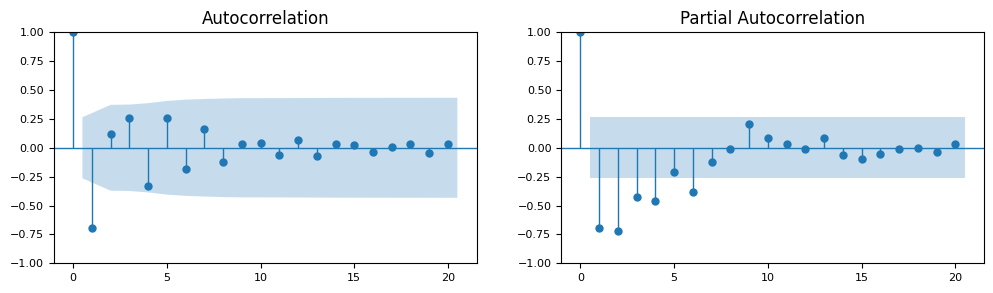

In [428]:
#Визуализация ряда и его последовательных "производных" до 3его порядка
diff_row = train_df.copy()

for i in range(4):
    diff_row = diff_row.diff().dropna()

#Построим кореллограммы для 3его производного ряда, чтобы определиться с параметрами p и q
fig, ax = plt.subplots(1, 2, figsize=(12,3))

sgt.plot_acf(diff_row, ax=ax[0], lags=20)
sgt.plot_pacf(diff_row, ax=ax[1], lags=20, method="ywm")
plt.show()

- - -
    Как и ожидалось от изменения одного значения ничего не поменялось

12. Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [429]:
#Не поленимся и даже посчитаем AIC для всех параметров p, которые мы перебирали в первый раз
for i in list(range(2,9)):
    arima_model = ARIMA(train_df, order=(i, 3, 1))
    arima_model_fit = arima_model.fit()
    print(f'При p = {i}, AIC = {arima_model_fit.aic}')

При p = 2, AIC = 2659.2261049694457
При p = 3, AIC = 2660.791302665225
При p = 4, AIC = 2647.816973912171
При p = 5, AIC = 2646.806775555751
При p = 6, AIC = 2628.9546394497665
При p = 7, AIC = 2626.621962378994
При p = 8, AIC = 2628.7648729030243


- - -
    Значение при p=4 сравним. Было 2647.935669815345. Есть отличие в десятых. Надо призначть метрика AIC заметила изменения. Я думал, вообще не заметит впроть до 5го знака где-нибудь.
    Теперь стало интересно оценить визуально прогнозы для тех же p, что уже сделали (выбросим только 7 и 8, как уж точно не годные, а добавленные в прошлый раз только лишь из-за любопытства)

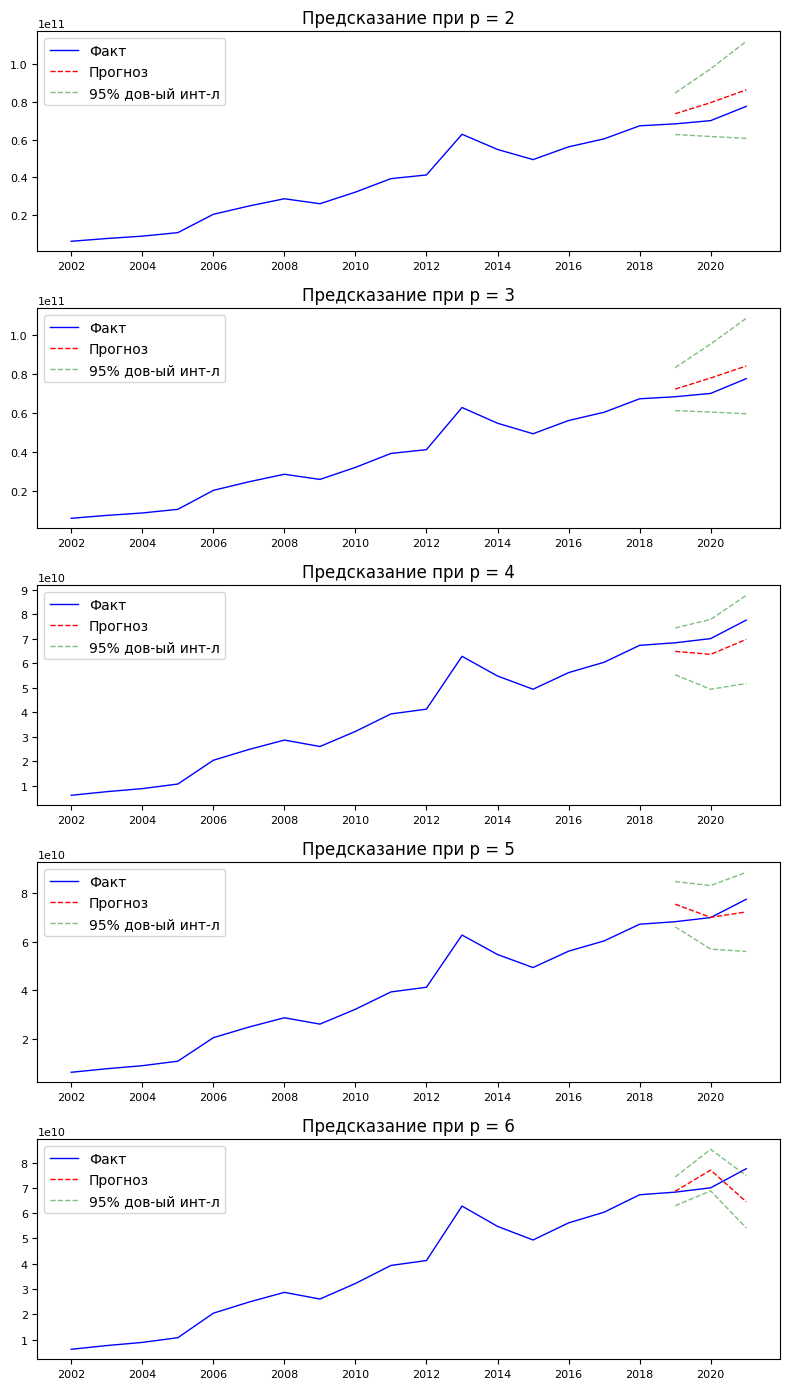

In [430]:
#Зададим список значений p для которых будем делать прогноз и рисовать график. 
p_list = [2,3,4,5,6]
fig, axes = plt.subplots(len(p_list), 1, figsize=(8,14))


for i,p in enumerate(p_list):
    #Обучим модель для каждого p из списка
    arima_model = ARIMA(train_df, order=(p, 3, 1))
    arima_model_fit = arima_model.fit()
    #Создадим таблицу итоговых данных для визуализации результатов по текущей модели
    pred_df = pd.DataFrame(index=data.index)
    pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
    pred_df["gpd"] = data["gpd"]
    forecast = arima_model_fit.get_forecast(len(test_df.index))
    forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
    pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gpd"]
    pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gpd"]
    pred_df = pred_df.iloc[-20:,:]
    #Собственно нарисум резельтат модели при текущем p на i-ой оси
    label = 'Предсказание при p = '+str(p)
    ax = axes[i]
    
    ax.plot(pred_df["gpd"], color="blue", label="Факт")
    ax.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="--",label="Прогноз")
    ax.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="95% дов-ый инт-л",alpha=0.5)
    ax.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.5)
    ax.set_title(label)
    ax.legend()

plt.tight_layout()

- - -
    Да нет никакой разницы, как и ожидалось. Но это в этом случае. Понятно, что если бы занчений таких было не одно из 59 в треннировочной выборке, а больше, то на результатах модели это бы сказалось

13. Протестируем как работает кросс-валидационное разбиение для рядов

Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

In [431]:
from sklearn.model_selection import TimeSeriesSplit
Split = TimeSeriesSplit(n_splits=3, test_size=7)
Split.split(data)
for (train, test) in Split.split(data):
    print(train)
    print (test)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[41 42 43 44 45 46 47]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
[55 56 57 58 59 60 61]


- - -
    Интересно, что на выходе получили порядковые индексы по Серии, а не индексы, которые были в серии индексами.

14. Посчитайте волатильность для вашего временного ряда.

In [432]:
data["gpd_vol"] = data['gpd'].pct_change(1).mul(100).abs() #pct_change - отклонение в процентах
data.head(7)

,gpd,gpd_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
1965-01-01,2.053221e+09,18.608414
1966-01-01,2.126050e+09,3.547067


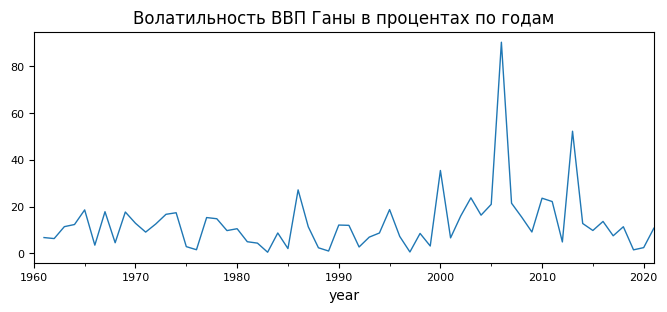

In [433]:
plt.rcParams["figure.figsize"] = 8, 3
data["gpd_vol"].plot()
plt.title('Волатильность ВВП Ганы в процентах по годам')
plt.show()


15. Используйте GARCH-модель для предсказания волатильности.

In [434]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

- - -
    Прежде чем что-то предсказывать, проверим на стационарность на ряд волатильности

In [435]:
get_static_depth(train_df['gpd_vol'].iloc[1:])  

0

- - -
    Ряд волатильности стационарен. Теперь определим параметры по кореллограммам

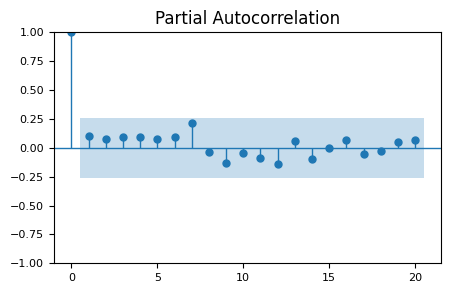

In [436]:
plt.rcParams["figure.figsize"] = 5, 3

sgt.plot_pacf(train_df['gpd_vol'].iloc[1:], lags=20, method="ywm")
plt.show()

- - -
    В общем, берем первый лаг и все. Одно я не понял, какой из параметров по этой коррелограмме подбирается для модели GARCH. Или эту модель обычно испольщуют при p=q. Ответа на этот вопрос я не увидел ни в материалах курса, ни в 3х видео по ARCH/GARCH, ни в документации, нигде блин. В чате модуля написано, мол, подбирайте как раньше p и q подбирали. Но почему? Это ж не они вроде.

In [437]:
garch_df = pd.DataFrame(data["gpd_vol"].loc[data.index])
garch_df.loc[train_df.index, "gpd_vol"] = train_df["gpd_vol"].dropna()

from arch import arch_model
model = arch_model(garch_df["gpd_vol"].dropna(), p=1, q=1)
model_results = model.fit(last_obs=test_df.index[0], update_freq=1)
model_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.9755861825515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551668535086
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253911783457
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.153813350104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.88223730003082
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.3848318221798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.38840967935226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.23867960370163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.90954513471712
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.87183210880022
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.92958507527516
Iteration:     14,   Func. Count:     83,   Neg. LLF: 22

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gpd_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Mon, Jul 24 2023   Df Residuals:                       57
Time:                        22:24:11   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [438]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

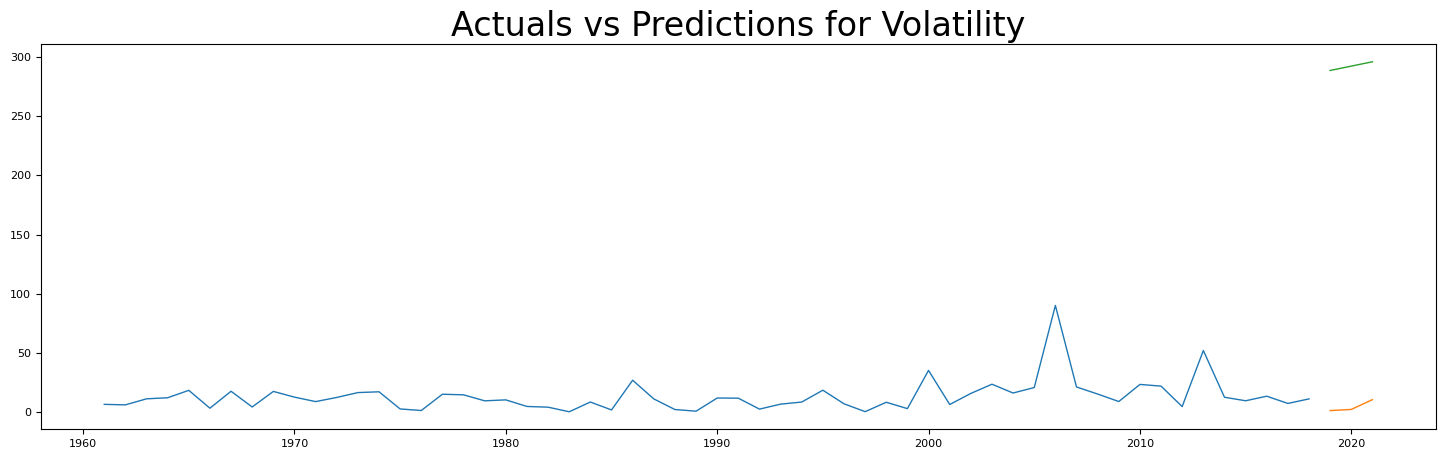

In [439]:
plt.rcParams["figure.figsize"] = 18, 5


plt.plot(train_df["gpd_vol"].abs())
plt.plot(predictions_df["gpd_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for Volatility", size=24)

plt.show()

- - -
    Если честно, я искал ошибку, но не нашел. Тут без всякой линейной регрессии видно, что garch показывает температуру на Венере, а не волатильность. Я бы даже сказал по-другому, модель говорит, что дисперсия может быть ОЧЕНЬ БОЛЬШАЯ, точнее не спрашивайте!

    Или есть ошибка. Просьба прокомментировать проеряющего ментора, если есть ошибка, т.к. для меня это оказалось самым демотивирующим заданием практическим из всего курса.

16. Используйте линейную регрессию для получения прогноза.

In [440]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gpd_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gpd_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gpd_vol"].fillna(0)
y_test = test_df["gpd_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)




17. Визуализируйте полученное предсказание вместе с фактическим значением.

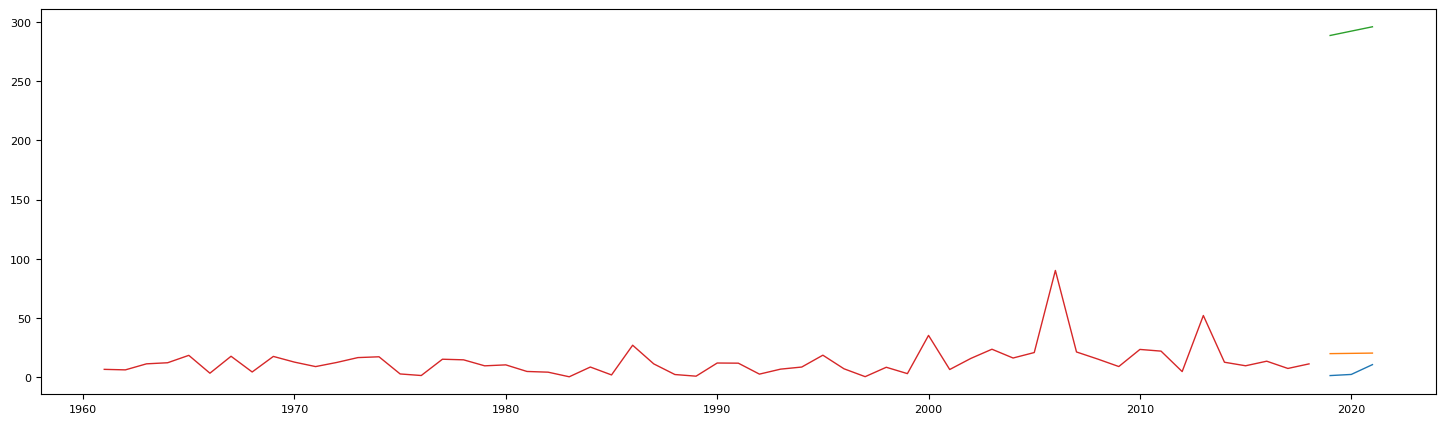

In [441]:
plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.plot(predictions_df["Predictions"])
plt.plot(train_df["gpd_vol"].abs())
plt.show()

18. Сравните результаты и сделайте выводы.
19. Почему результат модели GARCH получился именно таким?

- - -
    Если моя GARCH модель построена корректно, то у меня гипотеза такая - т.к. "прыжки" в конце редкие и усиливаются модель прогнозирует, что-то типа "может быть все, что угодно" , а тренд на оченьт большорй рост волатильности. И там как-нибудь квадратичная зависимость в формуле это модели уводит в большие значения. При этом какого-то типичного поведения графика, каких-то паттернов нет, только четкий тренд на увеличение разброса. Не уверен в корректности такого вывода из-за того что сильно неадкватный реальности результат. 